In [4]:
from IPython.display import display, HTML # import from core is deprecated
css_file = './custom.css'
HTML(open(css_file, "r").read())

###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT License. (c)2014 [David I. Ketcheson](http://davidketcheson.info)

##### version 0.1 - May 2014

# High-resolution methods

$$
\newcommand{\Dx}{\Delta x}
\newcommand{\Dt}{\Delta t}
\newcommand{\imh}{{i-1/2}}
\newcommand{\iph}{{i+1/2}}
\newcommand{\DQ}{\Delta Q}
\newcommand{\sgn}{\mathrm{sgn}}
$$
The methods we have used so far (the *upwind method* and the *Lax-Friedrichs method*) are both dissipative.  This means that over time they artificially smear out the solution -- especially shocks.  Furthermore, both of these methods are only *first order accurate*, meaning that if we reduce the values of $\Dt$ and $\Dx$ by a factor of two, the overall error decreases (only) by a factor of two.  We can do better.

## Reducing dissipation

The first step in improving our accuracy is to use a more accurate representation of $q(x)$ at each step.  Instead of assuming that $q$ is piecewise-constant, we will now approximate it by a piecewise-linear function:

$$q(x) = Q^n_i + \sigma^n_i (x-x_i).$$

Here $\sigma_i$ represents the slope in cell $i$.  The most obvious choice to ensure that this results in a second-order accurate approximation is to take the centered approximation

$$\sigma^n_i = \frac{Q^n_{i+1} - Q^n_{i-1}}{2\Dx}.$$

We use this to obtain values at the cell interfaces:

\begin{align}
q^+_\imh & = Q_i - \sigma_i \frac{\Dx}{2} \\
q^-_\iph & = Q_i + \sigma_i \frac{\Dx}{2}.
\end{align}

![](./figures/linear_reconstruction.png)

We'll use these interface values to approximate the flux, based on the **Lax-Friedrichs flux**:

$$F_\imh = \frac{1}{2} \left( f(q^-_\imh) + f(q^+_\imh) - \frac{\Dt}{\Dx} (q^+_\imh - q^-_\imh)\right)$$

This provides second-order accuracy in space.  We also need to make the method second-order accurate in time.  We can do so by using a second-order Runge--Kutta method.  Then the full method is

\begin{align}
Q^*_i & = Q^n_i - \frac{\Dt}{\Dx}\left( F^n_\iph - F^n_\imh \right) \\
Q^{n+1}_i & = \frac{1}{2} Q^n_i + \frac{1}{2} Q^*_i - \frac{\Dt}{2\Dx}\left( F^*_\iph - F^*_\imh \right) \\
\end{align}

In [5]:
%matplotlib widget
import sys
sys.path.append('./util')
from ianimate import ianimate
import numpy as np

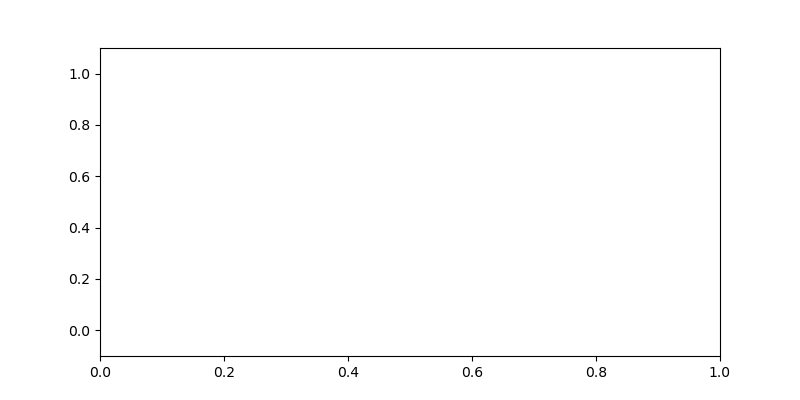

In [6]:
def f(q):
    return q*(1.0-q)

m = 100     # number of points
dx = 1./m   # Size of 1 grid cell
x = np.arange(-3*dx/2, 1.+5*dx/2, dx)

t = 0. # Initial time
T = 0.5 # Final time
dt = 0.9 * dx  # Time step

Q = 0.9*np.exp(-100*(x-0.5)**2)
Qnew = np.zeros(m+4)
Qstar = np.zeros(m+4)
sigma = np.zeros(m+4)

F = np.zeros(m+4)
QQ = [Q]

while t < T:
    
    sigma[1:-1]  = (Q[2:] - Q[:-2])/(2.0*dx)
    qplus  = Q[1:-1] - sigma[1:-1] * dx/2.0  # q^+_{i-1/2}
    qminus = Q[:-2] + sigma[:-2]  * dx/2.0  # q^-_{i-1/2}
    F[1:-1] = 0.5*(f(qplus)+f(qminus) - dx/dt*(qplus-qminus) )# F_{i-1/2}
    
    Qstar[2:-2] = Q[2:-2] - dt/dx*(F[3:-1]-F[2:-2])
    Qstar[0:2] = Qstar[2]
    Qstar[-2:] = Qstar[-3]
    
    sigma[1:-1]  = (Qstar[2:] - Qstar[:-2])/(2.0*dx)
    qplus  = Qstar[1:-1] - sigma[1:-1] * dx/2.0  # q^+_{i-1/2}
    qminus = Qstar[:-2] + sigma[:-2]  * dx/2.0  # q^-_{i-1/2}
    F[1:-1] = 0.5*(f(qplus)+f(qminus) - dx/dt*(qplus-qminus) )# F_{i-1/2}
    
    Qnew[2:-2] = 0.5*Q[2:-2] + 0.5*(Qstar[2:-2] - dt/dx*(F[3:-1]-F[2:-2]))
        
    Q = Qnew.copy()
    Q[0:2] = Q[2]
    Q[-2:] = Q[-3]
    t = t + dt
    QQ.append(Q)
    
ianimate(x,QQ)

The shock wave is much sharper now, but we have a new problem. Do you see the little dip behind the shock?  If you look closely, you'll see that the solution is actually negative there!  Obviously, a negative density of cars makes no sense.  What's more, the solution shouldn't dip there -- and it shouldn't have that funny bump just in front of the shock either.  What to do?

## Slope limiting

The spurious oscillations in our solution are not a particular feature of the method we've chosen.  In fact, *any* second-order (or higher) method that computes $q^\pm_\imh$ as a linear function of the cell averages will have oscillations (this is a famous result known as *Godunov's Theorem*).

We can get around this difficulty by choosing the slope $\sigma$ as a *nonlinear* function of the cell averages.  In particular, to avoid oscillations we can choose the smaller of the two one-sided slopes.  Let $\DQ_\imh = Q_i - Q_{i-1}$.  Then we use the slope

\begin{align}
\sigma_i & = \text{minmod}(\DQ_\imh,\DQ_\iph)/\Dx \\
& = \begin{cases} \min(\DQ_\imh, \DQ_\iph)/\Dx & \text{ if } \DQ_\imh, \DQ_\iph > 0 \\
\max(\DQ_\imh, \DQ_\iph)/\Dx & \text{ if } \DQ_\imh, \DQ_\iph < 0 \\
0 & \text{ if } \DQ_\imh\cdot \DQ_\iph < 0.
\end{cases}
\end{align}

This choice of slope is known as the minimum-modulus, or *minmod* slope.

## Local Lax-Friedrichs flux

The Lax-Friedrichs flux ensures that our solution is stable, but it does so by adding a lot of dissipation everywhere.  In fact, we could get away with using less dissipation over most of the domain.  A variant that does this is called the **local Lax-Friedrichs flux**.  It is little more accurate than the Lax-Friedrichs flux because it uses the local characteristic speeds to determine how much dissipation is needed at each interface.  It is

$$F_\imh = \frac{1}{2} \left( f(q^-_\imh) + f(q^+_\imh) - \alpha_\imh\frac{\Dt}{\Dx} (q^+_\imh - q^-_\imh)\right)$$

where

$$\alpha_\imh = \min(\left|f'(q^-_\imh)\right|,\left|f'(q^+_\imh)\right|).$$

### Exercise

In the cell below, copy and modify the second-order method above to use the minmod slope and local Lax-Friedrichs flux.  

*Hint 1*: You will want to use the functions `np.minimum` and `np.maximum`, which compare two arrays elementwise (not `np.min`, which finds the minimum of a single array).

*Hint 2*: to avoid using a loop for the slope computation, note that the minmod function can be written as
$$
\text{minmod}(a,b) = \frac{\sgn(a)+\sgn(b)}{2} \min(|a|,|b|).
$$
The signum  function is implemented as `np.sign()`. 

As you can see (after completing the exercise), this method keeps the shock fairly sharp and avoids the creation of negative solution values.  This method falls into the class of [MUSCL]() schemes and is proven to avoid oscillations.

## High-order methods

Just like the method we implemented above, most methods that are more than first-order accurate consist of three components:
1. **Reconstruction**: A method for computing interface values $q^\pm_\imh$ from cell averages $Q_i$.  This involves some kind of limiting in order to avoid oscillations.  Higher-order reconstruction is often done using [weighted essentially non-oscillatory (WENO)](http://www.dam.brown.edu/scicomp/media/report_files/BrownSC-2006-21.ps.gz) methods.
2. **Numerical flux**:  An approximation of the flux, computed based on the interface values $q^\pm_\imh$.  The Lax-Friedrichs flux above is one of the simplest.  Much more accurate fluxes can be computed using an exact or approximate [Riemann solver](http://en.wikipedia.org/wiki/Riemann_solver).
3. **Time integrator**: In order to get high-order accuracy in time, usually a [Runge-Kutta method](http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) is used.  [Strong stability preserving methods](http://www.davidketcheson.info/assets/papers/sspreview.pdf) are particularly popular.

It's possible to devise methods of very high order by increasing the order of the polynomial reconstruction and of the time integrator.